In [1]:
import numpy as np
from scipy import sparse
from scipy.linalg import cholesky, solve_triangular
from scipy.io import loadmat
import time
import matplotlib.pyplot as plt

In [2]:
def cov_matern(d, loghyper, x):
    ell = np.exp(loghyper[0])
    sf2 = np.exp(2 * loghyper[1])    
    def f(t):
        if d == 1: return 1
        if d == 3: return 1 + t
        if d == 5: return 1 + t * (1 + t / 3)
        if d == 7: return 1 + t * (1 + t * (6 + t) / 15)       
    def m(t):
        return f(t) * np.exp(-t)   
    dist_sq = ((x[:, None] - x[None, :]) / ell) ** 2
    return sf2 * m(np.sqrt(d * dist_sq))

def RL_precision(logbeta, A):
    beta = np.exp(logbeta)    
    A = np.asarray(A, dtype=float)
    n = A.shape[0]
    A = A - np.eye(n)
    iD = np.diag(1 / np.sqrt(A.sum(axis=0))) 
    Lap = np.eye(n) - iD @ A @ iD    
    return np.eye(n) + beta * Lap

In [3]:
def compute_factor_term(G, mask, Y, dim):
    Psi = sparse.kron(G, sparse.eye(dim, format="csr"), format="csr")
    mask_vec = (np.asarray(mask).ravel(order="F") == 1)
    rows = np.flatnonzero(mask_vec)
    Psi_mask = Psi[rows, :]
    HH = Psi_mask.T @ Psi_mask
    y_obs = np.asarray(Y).ravel(order="F")[mask_vec].reshape(-1, 1)
    Hy = Psi_mask.T @ y_obs
    return HH, Hy

def compute_likeli_term(invK, R, tau, HH, Hy):
    invSigma = sparse.kron(sparse.eye(R, format="csr"), invK, format="csr")
    Lambda = (tau * HH + invSigma).toarray()
    cholL = cholesky(Lambda)
    uu = solve_triangular(cholL.T, Hy, lower=True)
    likeli_temp = 0.5 * (tau ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholL)))
    return invSigma, cholL, likeli_temp

def compute_likeli_KU(tau, invKu, HHU, HyU, R):
    invKU, cholLU, likeli_temp = compute_likeli_term(invKu, R, tau, HHU, HyU)
    cholLu = cholesky(invKu)
    likeli_KU = likeli_temp + R * np.sum(np.log(np.diag(cholLu)))
    return cholLu, invKU, cholLU, likeli_KU

def compute_likeli_KV(tau, Kv, HHV, HyV, R):
    eigvalKv, Qvt = np.linalg.eigh(Kv)
    invKv = Qvt @ np.diag(1.0 / eigvalKv) @ Qvt.T
    invKV, cholLV, likeli_temp = compute_likeli_term(invKv, R, tau, HHV, HyV)
    likeli_KV = likeli_temp + 0.5 * R * np.sum(np.log(eigvalKv))
    return eigvalKv, invKV, cholLV, likeli_KV

def prior_theta(hpri, theta):
    mu, lamb = hpri
    return -0.5 * lamb * (theta-mu) ** 2

def theta_range(ranges, theta, min_hp, max_hp):
    tempt = ranges * np.random.rand()
    tmin = max(theta - tempt, min_hp)
    tmax = min(tmin + ranges, max_hp)
    return tmin, tmax

def hyperU_RL_marginal(theta_est, ranges, likeli, tau, HHU, HyU, min_hp, max_hp, hpri, A, R):
    PU = likeli + prior_theta(hpri, theta_est)  
    tmin, tmax = theta_range(ranges, theta_est, min_hp, max_hp)
    logu = np.log(np.random.rand())
    while True:
        theta_next = tmin + (tmax - tmin) * np.random.rand()
        invKu_next = RL_precision(theta_next, A)        
        cholLu, invKU_next, cholLU, likeli_next = compute_likeli_KU(tau, invKu_next, HHU, HyU, R)
        PU_next = likeli_next + prior_theta(hpri, theta_next)
        if PU_next - PU > logu:
            return theta_next, invKU_next, cholLU, cholLu, likeli_next
        elif theta_next < theta_est:
            tmin = theta_next
        else:
            tmax = theta_next

def hyperV_Matern_marginal(theta_est, ranges, likeli, tau, HHV, HyV, min_hp, max_hp, hpri, d_Matern, matern_var, T, R):    
    PV = likeli + prior_theta(hpri, theta_est)
    tmin, tmax = theta_range(ranges, theta_est, min_hp, max_hp)
    logu = np.log(np.random.rand())
    while True:
        theta_next = tmin + (tmax - tmin) * np.random.rand()
        Kv_next = cov_matern(d_Matern, [theta_next, np.log(matern_var)], np.arange(1, T + 1))
        eigvalKv, invKV_next, cholLV, likeli_next = compute_likeli_KV(tau, Kv_next, HHV, HyV, R)
        PV_next = likeli_next + prior_theta(hpri, theta_next)
        if PV_next - PV > logu:
            return theta_next, invKV_next, cholLV, eigvalKv, likeli_next
        elif theta_next < theta_est:
            tmin = theta_next
        else:
            tmax = theta_next

In [4]:
def mvnrnd_pre_ch(mean, chol_prec):
    z = np.random.randn(mean.shape[0], 1)
    return mean + solve_triangular(chol_prec, z, lower=False)

def sample_factor(tau, cholL, Hy, N):
    tmp = solve_triangular(cholL.T, Hy, lower=True)
    Mean = tau * solve_triangular(cholL, tmp, lower=False)
    temp_vec = mvnrnd_pre_ch(Mean, cholL)
    return temp_vec.reshape((N[0], N[1]), order="F")

In [5]:
def sample_tau(Y, Y_est, mask_matrix, num_obser, a0, b0):
    Err = np.linalg.norm((Y - Y_est) * mask_matrix, ord='fro')**2
    a_tau = a0 + 0.5 * num_obser
    b_tau = b0 + 0.5 * Err
    return np.random.gamma(shape=a_tau, scale=1.0 / b_tau)

In [6]:
def compute_mae(Y, Y_est, mask_test):
    return np.sum(np.abs(Y_est - Y) * mask_test) / np.sum(mask_test)

def compute_rmse(Y, Y_est, mask_test):
    return np.sqrt((np.linalg.norm((Y - Y_est) * mask_test, ord="fro")**2) / np.sum(mask_test == 1))

In [7]:
def BKMF(I, Omega, mask_test, U_gra_scale, V_matern_scale, V_matern_var, ranges, min_hp, max_hp, hpri, A, d_Matern, a0, b0, R, burn_iter, pos_iter, start):
    N = np.array(I.shape)
    D = I.ndim
    num_obser = np.sum(Omega)
    mask_matrix = [Omega, Omega.T]
    
    train_matrix = I * Omega
    train_matrix = train_matrix[train_matrix > 0]
    Isubmean = I - np.mean(train_matrix)
    I_train = Isubmean * Omega
    Y_train = [I_train, I_train.T]
    
    G = [0.1 * np.random.randn(N[d], R) for d in range(D)]
    
    max_iter = burn_iter + pos_iter
    mae = np.zeros(max_iter)
    rmse = np.zeros(max_iter)
    G_save = [np.zeros((N[d], R, pos_iter)) for d in range(D)]
    hyper_K = np.zeros((max_iter + 1, D))
    
    hyper_K[0, 0] = np.log(U_gra_scale)
    hyper_K[0, 1] = np.log(V_matern_scale)
    invKu = RL_precision(hyper_K[0, 0], A)
    Kv = cov_matern(d_Matern, [hyper_K[0, 1], np.log(V_matern_var)], np.arange(1, N[1] + 1))
    
    HH = [None] * D
    Hy = [None] * D
    for d in range(D):
        HH[d], Hy[d] = compute_factor_term(G[1-d], mask_matrix[d], Y_train[d], N[d])
    
    tau = np.zeros(max_iter + 1)
    tau[0] = 1e-2
    cholLu, invKU, cholLU, likeli_KU = compute_likeli_KU(tau[0], invKu, HH[0], Hy[0], R)
    eigvalKv, invKV, cholLV, likeli_KV = compute_likeli_KV(tau[0], Kv, HH[1], Hy[1], R)
    
    Y_est_sum = 0
    Y_est_sum2 = 0
    for it in range(burn_iter + pos_iter):
        hyper_K[it+1, 0], invKU, cholLU, cholLu, likeli_KU = hyperU_RL_marginal(
            hyper_K[it, 0], ranges[0], likeli_KU, tau[it], HH[0], Hy[0], min_hp[0], max_hp[0], hpri[0], A, R)

        hyper_K[it+1, 1], invKV, cholLV, eigvalKv, likeli_KV = hyperV_Matern_marginal(
            hyper_K[it, 1], ranges[1], likeli_KV, tau[it], HH[1], Hy[1], min_hp[1], max_hp[1], hpri[1], d_Matern, V_matern_var, N[1], R)
        
        G[0] = sample_factor(tau[it], cholLU, Hy[0], G[0].shape)
        
        HH[1], Hy[1] = compute_factor_term(G[0], mask_matrix[1], Y_train[1], N[1])
        LambdaV = (tau[it] * HH[1] + invKV).toarray()
        cholLV = cholesky(LambdaV)
        G[1] = sample_factor(tau[it], cholLV, Hy[1], G[1].shape)
        
        Y_est = G[0] @ G[1].T
        
        tau[it + 1] = sample_tau(Isubmean, Y_est, mask_matrix[0], num_obser, a0, b0)
        
        if it >= burn_iter:
            st_it = it - burn_iter
            for d in range(D):
                G_save[d][:, :, st_it] = G[d]
            Y_est_sum2 = Y_est_sum2 + Y_est
        
        Y_est_sum = Y_est_sum + Y_est
        Y_est_ave = Y_est_sum/(it + 1)
        
        mae[it] = compute_mae(Isubmean, Y_est_ave, mask_test)
        rmse[it] = compute_rmse(Isubmean, Y_est_ave, mask_test)
        
        print(f"Epoch = {it + 1}, tau = {tau[it + 1]}, mae = {mae[it]}, rmse = {rmse[it]}")
        end = time.time()
        print('Running time: %d seconds'%(end - start))
        
        HH[0], Hy[0] = compute_factor_term(G[1], mask_matrix[0], Y_train[0], N[0])
        LambdaU = (tau[it + 1] * HH[0] + invKU).toarray()
        cholLU = cholesky(LambdaU)
        uu = solve_triangular(cholLU.T, Hy[0], lower=True)
        likeli_KU = 0.5 * (tau[it + 1] ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholLU))) + R * np.sum(np.log(np.diag(cholLu)))
        
        LambdaV = (tau[it + 1] * HH[1] + invKV).toarray()
        cholLV = cholesky(LambdaV)
        uu = solve_triangular(cholLV.T, Hy[1], lower=True)
        likeli_KV = 0.5 * (tau[it + 1] ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholLV))) + 0.5 * R * np.sum(np.log(eigvalKv))
        
    return G, G_save, hyper_K, tau, mae, rmse, Y_est_sum2/pos_iter + np.mean(train_matrix)

In [8]:
seedr = 6
np.random.seed(seedr)
A = loadmat('../data/traffic/seattle/seattle_adj.mat')['A']
I = loadmat('../data/traffic/seattle/sedata_amonth_matrix.mat')['data_matrix']
N = I.shape
Omega_raw = (I != 0).astype(np.int8)

missing_rate = 0.5 # Random missing (RM)
mask_matrix = (np.round(np.random.rand(N[0], N[1]) + 0.5 - missing_rate)).astype(np.int8)
mask_matrix = mask_matrix & Omega_raw
mask_test = (1 - mask_matrix) & Omega_raw

U_gra_scale = 1
V_matern_scale = 1
V_matern_var = 1
ranges = [np.log(10), np.log(10)]
min_hp = [np.log(1e-3), np.log(1e-6)]
max_hp = [np.log(1e3), np.log(1e6)]
hpri = [None] * 2
hpri[0] = [np.log(10), 1]
hpri[1] = [np.log(10), 1]
d_Matern = 3
a0 = 1e-6
b0 = 1e-6
R = 10
burn_iter = 600
pos_iter = 400

start = time.time()
G, G_save, hyper_K, tau, mae, rmse, Y_est_ = BKMF(
    I, mask_matrix, mask_test, U_gra_scale, V_matern_scale, V_matern_var, ranges, min_hp, max_hp, hpri, A, d_Matern, a0, b0, R, burn_iter, pos_iter, start)

Epoch = 1, tau = 0.009424327425600745, mae = 6.972911452225675, rmse = 10.55944967479976
Running time: 7 seconds
Epoch = 2, tau = 0.03726763841840299, mae = 4.70805940581975, rmse = 7.195596743458786
Running time: 18 seconds
Epoch = 3, tau = 0.06184997249027984, mae = 3.7396579114585746, rmse = 5.828534580114282
Running time: 32 seconds
Epoch = 4, tau = 0.07780092363613209, mae = 3.215117017246788, rmse = 5.110530757843368
Running time: 48 seconds
Epoch = 5, tau = 0.08283680291502983, mae = 2.912175449500497, rmse = 4.703793449005476
Running time: 70 seconds
Epoch = 6, tau = 0.08507923843007073, mae = 2.7264089201749133, rmse = 4.459365685123468
Running time: 76 seconds
Epoch = 7, tau = 0.08547661779712094, mae = 2.604271055571238, rmse = 4.302291278354225
Running time: 101 seconds
Epoch = 8, tau = 0.08571641870515923, mae = 2.519283386595338, rmse = 4.1933716738031475
Running time: 117 seconds
Epoch = 9, tau = 0.08628574818426514, mae = 2.4577204359543883, rmse = 4.115692174929721
Run

Epoch = 72, tau = 0.08597576741993108, mae = 2.214701937082452, rmse = 3.826021801208972
Running time: 1399 seconds
Epoch = 73, tau = 0.08643395599946473, mae = 2.2145749314015175, rmse = 3.8260301980026896
Running time: 1429 seconds
Epoch = 74, tau = 0.08697901799555667, mae = 2.214587206850443, rmse = 3.8260271194449245
Running time: 1440 seconds
Epoch = 75, tau = 0.087227478033928, mae = 2.214573909115774, rmse = 3.8261286529574385
Running time: 1470 seconds
Epoch = 76, tau = 0.08592178790516346, mae = 2.214570942773544, rmse = 3.8260164634312135
Running time: 1492 seconds
Epoch = 77, tau = 0.08612369651054565, mae = 2.2144981689149894, rmse = 3.825985077515899
Running time: 1507 seconds
Epoch = 78, tau = 0.08674784494893148, mae = 2.2145205527771634, rmse = 3.82606944178245
Running time: 1515 seconds
Epoch = 79, tau = 0.08667788875854739, mae = 2.2145668441715705, rmse = 3.8261374124279244
Running time: 1538 seconds
Epoch = 80, tau = 0.08686749376114879, mae = 2.2145135478371216, r

Epoch = 142, tau = 0.08697693875996307, mae = 2.2153845039291853, rmse = 3.8288881225224123
Running time: 2926 seconds
Epoch = 143, tau = 0.08683891045004324, mae = 2.215398406883868, rmse = 3.8289391387045595
Running time: 2941 seconds
Epoch = 144, tau = 0.08636862489149413, mae = 2.2154130177069584, rmse = 3.8290186805389967
Running time: 2956 seconds
Epoch = 145, tau = 0.08661766155697044, mae = 2.2153896871164287, rmse = 3.829060224838782
Running time: 2987 seconds
Epoch = 146, tau = 0.08675559859336893, mae = 2.215394451353713, rmse = 3.82904530357326
Running time: 3012 seconds
Epoch = 147, tau = 0.08711693920157874, mae = 2.215477853099697, rmse = 3.829160418362282
Running time: 3035 seconds
Epoch = 148, tau = 0.0876741894910395, mae = 2.2155453162268093, rmse = 3.829249869233197
Running time: 3054 seconds
Epoch = 149, tau = 0.08723726284735707, mae = 2.215620815476907, rmse = 3.8293547090190496
Running time: 3088 seconds
Epoch = 150, tau = 0.08710208596688679, mae = 2.2156151729

Epoch = 212, tau = 0.08664908154626215, mae = 2.2167997246581783, rmse = 3.8314605344081594
Running time: 4353 seconds
Epoch = 213, tau = 0.08639529882326066, mae = 2.2168358173909075, rmse = 3.8315025855290563
Running time: 4388 seconds
Epoch = 214, tau = 0.08659588361066912, mae = 2.216849372002371, rmse = 3.831548866985347
Running time: 4407 seconds
Epoch = 215, tau = 0.08687325641224718, mae = 2.216831505739642, rmse = 3.8315471778136416
Running time: 4424 seconds
Epoch = 216, tau = 0.08670712597560695, mae = 2.2167967668541237, rmse = 3.831514769103061
Running time: 4449 seconds
Epoch = 217, tau = 0.08643722121309767, mae = 2.2168072105915595, rmse = 3.8314867268802777
Running time: 4471 seconds
Epoch = 218, tau = 0.08647990979824649, mae = 2.2168588065880948, rmse = 3.8315381996262747
Running time: 4485 seconds
Epoch = 219, tau = 0.086761783636467, mae = 2.2168823811719673, rmse = 3.831566499053624
Running time: 4509 seconds
Epoch = 220, tau = 0.08682262881949075, mae = 2.2168670

Epoch = 282, tau = 0.0869945778390441, mae = 2.2173894150242015, rmse = 3.8323980080570066
Running time: 5810 seconds
Epoch = 283, tau = 0.0872504678230295, mae = 2.2173858377344553, rmse = 3.832410569783943
Running time: 5846 seconds
Epoch = 284, tau = 0.08683828895475455, mae = 2.2173914104711483, rmse = 3.832417834222542
Running time: 5858 seconds
Epoch = 285, tau = 0.08723680980301836, mae = 2.217393871129102, rmse = 3.832418398232653
Running time: 5877 seconds
Epoch = 286, tau = 0.08715127353185609, mae = 2.217372504094483, rmse = 3.832388567101632
Running time: 5897 seconds
Epoch = 287, tau = 0.08581368241366205, mae = 2.217366255225279, rmse = 3.8323862296008873
Running time: 5912 seconds
Epoch = 288, tau = 0.08628496678159245, mae = 2.2173567516183814, rmse = 3.8323786865478904
Running time: 5930 seconds
Epoch = 289, tau = 0.08649865602542375, mae = 2.2173595850769017, rmse = 3.8324003237273385
Running time: 5951 seconds
Epoch = 290, tau = 0.0866892327073675, mae = 2.2173642402

Epoch = 352, tau = 0.08682793084713916, mae = 2.217537362449774, rmse = 3.8327968774636783
Running time: 7316 seconds
Epoch = 353, tau = 0.08684971676954646, mae = 2.2175226587616894, rmse = 3.8328019179383777
Running time: 7332 seconds
Epoch = 357, tau = 0.08645288137515766, mae = 2.2175398541822284, rmse = 3.8328170888520328
Running time: 7418 seconds
Epoch = 358, tau = 0.08694300360723219, mae = 2.217561109122258, rmse = 3.832857370130709
Running time: 7446 seconds
Epoch = 359, tau = 0.08666289369430714, mae = 2.2175639134101646, rmse = 3.8328724143426784
Running time: 7472 seconds
Epoch = 360, tau = 0.08674214580578597, mae = 2.2175682098446146, rmse = 3.8328956029672407
Running time: 7499 seconds
Epoch = 361, tau = 0.08679996936563572, mae = 2.217566096628844, rmse = 3.8329059482177774
Running time: 7526 seconds
Epoch = 362, tau = 0.08737436177663224, mae = 2.2175656448656693, rmse = 3.8329236745283577
Running time: 7568 seconds
Epoch = 363, tau = 0.08691460068500559, mae = 2.2175

Epoch = 425, tau = 0.08712005223439448, mae = 2.217845268669659, rmse = 3.83343928136591
Running time: 8910 seconds
Epoch = 426, tau = 0.08685373840157926, mae = 2.217838404041723, rmse = 3.83343894009976
Running time: 8928 seconds
Epoch = 427, tau = 0.08663664084194077, mae = 2.2178371896874047, rmse = 3.8334516663652876
Running time: 8947 seconds
Epoch = 428, tau = 0.08671973627779592, mae = 2.217843933363496, rmse = 3.833470532229692
Running time: 8974 seconds
Epoch = 429, tau = 0.08627057324868562, mae = 2.217819355116345, rmse = 3.8334452191836856
Running time: 8981 seconds
Epoch = 430, tau = 0.0867553221501101, mae = 2.2178223934106707, rmse = 3.833461214904797
Running time: 9006 seconds
Epoch = 431, tau = 0.08738737947907765, mae = 2.217831245721982, rmse = 3.8334640287170907
Running time: 9040 seconds
Epoch = 432, tau = 0.08688626603070568, mae = 2.217834333110052, rmse = 3.8334653005302384
Running time: 9069 seconds
Epoch = 433, tau = 0.08685102095277426, mae = 2.2178126717049

Epoch = 495, tau = 0.08711933434384807, mae = 2.2181931149944223, rmse = 3.8337630277764765
Running time: 10365 seconds
Epoch = 496, tau = 0.0873074662704688, mae = 2.21820295548634, rmse = 3.8337686606219283
Running time: 10395 seconds
Epoch = 497, tau = 0.08640343944603317, mae = 2.2182072107535347, rmse = 3.8337777375749034
Running time: 10417 seconds
Epoch = 498, tau = 0.08666818984983196, mae = 2.218223117401893, rmse = 3.8338062966719844
Running time: 10431 seconds
Epoch = 499, tau = 0.08654339917219214, mae = 2.2182318770292953, rmse = 3.833800106821396
Running time: 10461 seconds
Epoch = 500, tau = 0.08658233149392018, mae = 2.2182494826990893, rmse = 3.833806536228315
Running time: 10478 seconds
Epoch = 501, tau = 0.08690023873412618, mae = 2.2182564682336494, rmse = 3.833796245672205
Running time: 10499 seconds
Epoch = 502, tau = 0.08651520583568603, mae = 2.2182449416137584, rmse = 3.833793554024299
Running time: 10514 seconds
Epoch = 503, tau = 0.08620995320615102, mae = 2.

Epoch = 564, tau = 0.0867085293010958, mae = 2.2184113837884274, rmse = 3.8340855875600277
Running time: 11790 seconds
Epoch = 565, tau = 0.08654906580725069, mae = 2.2184117785302733, rmse = 3.834076347619863
Running time: 11802 seconds
Epoch = 566, tau = 0.08653189084854235, mae = 2.218412587660644, rmse = 3.8340711453198795
Running time: 11819 seconds
Epoch = 567, tau = 0.086892390155261, mae = 2.2184174757805732, rmse = 3.83405838753721
Running time: 11848 seconds
Epoch = 568, tau = 0.08687228365070739, mae = 2.218428568034064, rmse = 3.8340594022919756
Running time: 11858 seconds
Epoch = 569, tau = 0.08725454997770628, mae = 2.218430501834602, rmse = 3.834079138862866
Running time: 11886 seconds
Epoch = 570, tau = 0.08639454742825224, mae = 2.218431159069056, rmse = 3.834085772596147
Running time: 11913 seconds
Epoch = 571, tau = 0.08679899683409976, mae = 2.218439526048146, rmse = 3.834093656101376
Running time: 11923 seconds
Epoch = 572, tau = 0.08712290781446577, mae = 2.218454

Epoch = 634, tau = 0.0862393166728037, mae = 2.2185995680160375, rmse = 3.834105012390826
Running time: 13379 seconds
Epoch = 635, tau = 0.08664257568101548, mae = 2.218598198808656, rmse = 3.8341002519151965
Running time: 13405 seconds
Epoch = 636, tau = 0.08650981818013036, mae = 2.218587948418497, rmse = 3.834098994299761
Running time: 13442 seconds
Epoch = 637, tau = 0.08646847209875491, mae = 2.2185969316793597, rmse = 3.834116524797666
Running time: 13487 seconds
Epoch = 638, tau = 0.08693146215518867, mae = 2.2186012919588505, rmse = 3.834113709652255
Running time: 13509 seconds
Epoch = 639, tau = 0.08708166312093218, mae = 2.2186030799532905, rmse = 3.834128265411509
Running time: 13534 seconds
Epoch = 640, tau = 0.08706987783174347, mae = 2.218591432486713, rmse = 3.83412854475258
Running time: 13551 seconds
Epoch = 641, tau = 0.08732762983466204, mae = 2.2185887491779126, rmse = 3.8341210325357182
Running time: 13568 seconds
Epoch = 642, tau = 0.08716040700182898, mae = 2.218

Epoch = 704, tau = 0.08655648594991858, mae = 2.218731526611573, rmse = 3.834351443586322
Running time: 14877 seconds
Epoch = 705, tau = 0.08604366942413637, mae = 2.21872605570349, rmse = 3.8343489066795775
Running time: 14906 seconds
Epoch = 706, tau = 0.08637098272801778, mae = 2.218723432820592, rmse = 3.8343467297684706
Running time: 14923 seconds
Epoch = 707, tau = 0.08713949403481162, mae = 2.2187170134003993, rmse = 3.834336082519909
Running time: 14956 seconds
Epoch = 708, tau = 0.08682793087161503, mae = 2.2187069374478616, rmse = 3.8343292842004173
Running time: 14980 seconds
Epoch = 709, tau = 0.0861228175287144, mae = 2.218712532882518, rmse = 3.8343393579953524
Running time: 15002 seconds
Epoch = 710, tau = 0.08640447197775951, mae = 2.218716184433319, rmse = 3.834354836172375
Running time: 15028 seconds
Epoch = 711, tau = 0.08701326140307059, mae = 2.218722795321883, rmse = 3.834357636273952
Running time: 15058 seconds
Epoch = 712, tau = 0.08753222569794114, mae = 2.2187

Epoch = 774, tau = 0.08684712802306736, mae = 2.218827860645209, rmse = 3.8344946338182857
Running time: 16355 seconds
Epoch = 775, tau = 0.0867971455914563, mae = 2.2188250437908827, rmse = 3.834498998347277
Running time: 16379 seconds
Epoch = 776, tau = 0.08655559516209353, mae = 2.218815918049373, rmse = 3.834488033928713
Running time: 16410 seconds
Epoch = 777, tau = 0.08677214031410233, mae = 2.2188163243902923, rmse = 3.8344891778640218
Running time: 16423 seconds
Epoch = 778, tau = 0.08633167857767024, mae = 2.2188128372266087, rmse = 3.834487722155034
Running time: 16439 seconds
Epoch = 779, tau = 0.0870687545377221, mae = 2.2188132167410775, rmse = 3.834483505013537
Running time: 16464 seconds
Epoch = 780, tau = 0.08630264310170184, mae = 2.2188047671987725, rmse = 3.83447555146609
Running time: 16480 seconds
Epoch = 781, tau = 0.08672845268018922, mae = 2.2188044210551485, rmse = 3.8344782510056907
Running time: 16525 seconds
Epoch = 782, tau = 0.0872348362966949, mae = 2.218

Epoch = 843, tau = 0.0860385518923079, mae = 2.218864120146851, rmse = 3.8346868651864487
Running time: 17882 seconds
Epoch = 844, tau = 0.08617848469043976, mae = 2.2188581501334594, rmse = 3.834687281417195
Running time: 17904 seconds
Epoch = 845, tau = 0.08710364049434116, mae = 2.218857139079909, rmse = 3.8346838224877917
Running time: 17916 seconds
Epoch = 846, tau = 0.08730476107030163, mae = 2.2188594024717934, rmse = 3.834688359024861
Running time: 17938 seconds
Epoch = 847, tau = 0.08649659755577851, mae = 2.218862019057897, rmse = 3.8346888575197546
Running time: 17978 seconds
Epoch = 848, tau = 0.08682990585537793, mae = 2.2188626936137137, rmse = 3.8346873734568794
Running time: 17995 seconds
Epoch = 849, tau = 0.08634971839094238, mae = 2.2188626018398194, rmse = 3.834688738032781
Running time: 18021 seconds
Epoch = 850, tau = 0.08679097074009685, mae = 2.2188586155839203, rmse = 3.834679583839371
Running time: 18050 seconds
Epoch = 851, tau = 0.08681687206731761, mae = 2.

Epoch = 912, tau = 0.08640063869246073, mae = 2.2188800375872413, rmse = 3.8347055865437425
Running time: 19450 seconds
Epoch = 913, tau = 0.08685786416621143, mae = 2.218888951351701, rmse = 3.834720954719518
Running time: 19478 seconds
Epoch = 914, tau = 0.08646507997359741, mae = 2.2188886641973187, rmse = 3.8347289299699594
Running time: 19494 seconds
Epoch = 915, tau = 0.0871173477767286, mae = 2.218892647518747, rmse = 3.834731763563645
Running time: 19521 seconds
Epoch = 916, tau = 0.08645972609620774, mae = 2.218889640120632, rmse = 3.8347300185159976
Running time: 19539 seconds
Epoch = 917, tau = 0.08751262088561751, mae = 2.218888633758373, rmse = 3.8347308200538768
Running time: 19557 seconds
Epoch = 918, tau = 0.08681304927121188, mae = 2.218885237109416, rmse = 3.834738067456548
Running time: 19573 seconds
Epoch = 919, tau = 0.08646015113231305, mae = 2.2188855120749493, rmse = 3.8347439349299752
Running time: 19604 seconds
Epoch = 920, tau = 0.08674442294322185, mae = 2.2

Epoch = 981, tau = 0.08662316840543922, mae = 2.2189612922019117, rmse = 3.834834832977203
Running time: 20907 seconds
Epoch = 982, tau = 0.08728503088787949, mae = 2.218961012560944, rmse = 3.834830143411378
Running time: 20928 seconds
Epoch = 983, tau = 0.0866131552402055, mae = 2.218965904075386, rmse = 3.8348281874026906
Running time: 20952 seconds
Epoch = 984, tau = 0.08676636948950217, mae = 2.2189646193118, rmse = 3.8348216904843904
Running time: 20977 seconds
Epoch = 985, tau = 0.08610883541040483, mae = 2.2189585186487513, rmse = 3.8348126877371573
Running time: 21000 seconds
Epoch = 986, tau = 0.08687245403606818, mae = 2.2189584785133905, rmse = 3.834813756232728
Running time: 21020 seconds
Epoch = 987, tau = 0.08656698403986747, mae = 2.218958607767969, rmse = 3.8348125616958946
Running time: 21033 seconds
Epoch = 988, tau = 0.08719169795662227, mae = 2.2189640925014946, rmse = 3.8348123954923468
Running time: 21043 seconds
Epoch = 989, tau = 0.08643925089176348, mae = 2.21

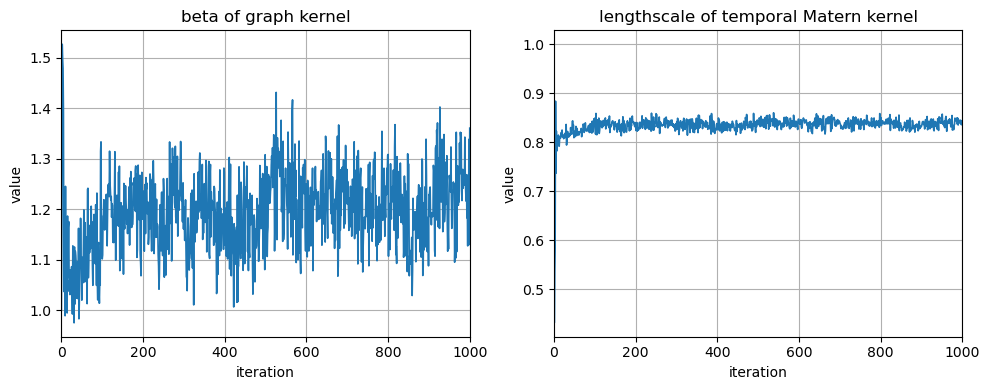

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

axes[0].plot(np.exp(hyper_K[:, 0]), linewidth=1.2)
axes[0].set_title("beta of graph kernel")
axes[0].grid(True)
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("value")
axes[0].set_xlim(0, len(hyper_K[:, 0]) - 1)

axes[1].plot(np.exp(hyper_K[:, 1]), linewidth=1.2)
axes[1].set_title("lengthscale of temporal Matern kernel")
axes[1].grid(True)
axes[1].set_xlabel("iteration")
axes[1].set_ylabel("value")
axes[1].set_xlim(0, len(hyper_K[:, 1]) - 1)

plt.show()

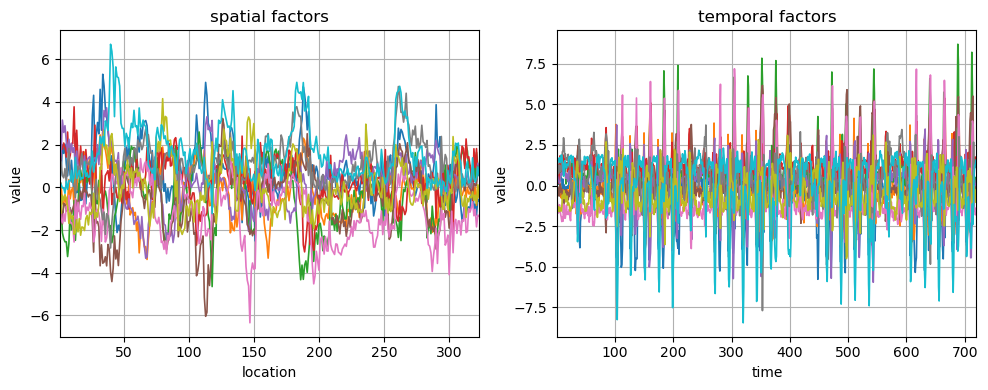

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
x = np.arange(1, N[0] + 1)
axes[0].plot(x, G[0], linewidth=1.2)
axes[0].set_title("spatial factors")
axes[0].grid(True)
axes[0].set_xlabel("location")
axes[0].set_ylabel("value")
axes[0].set_xlim(1, len(x))

x = np.arange(1, N[1] + 1)
axes[1].plot(G[1], linewidth=1.2)
axes[1].set_title("temporal factors")
axes[1].grid(True)
axes[1].set_xlabel("time")
axes[1].set_ylabel("value")
axes[1].set_xlim(1, len(x))

plt.show()

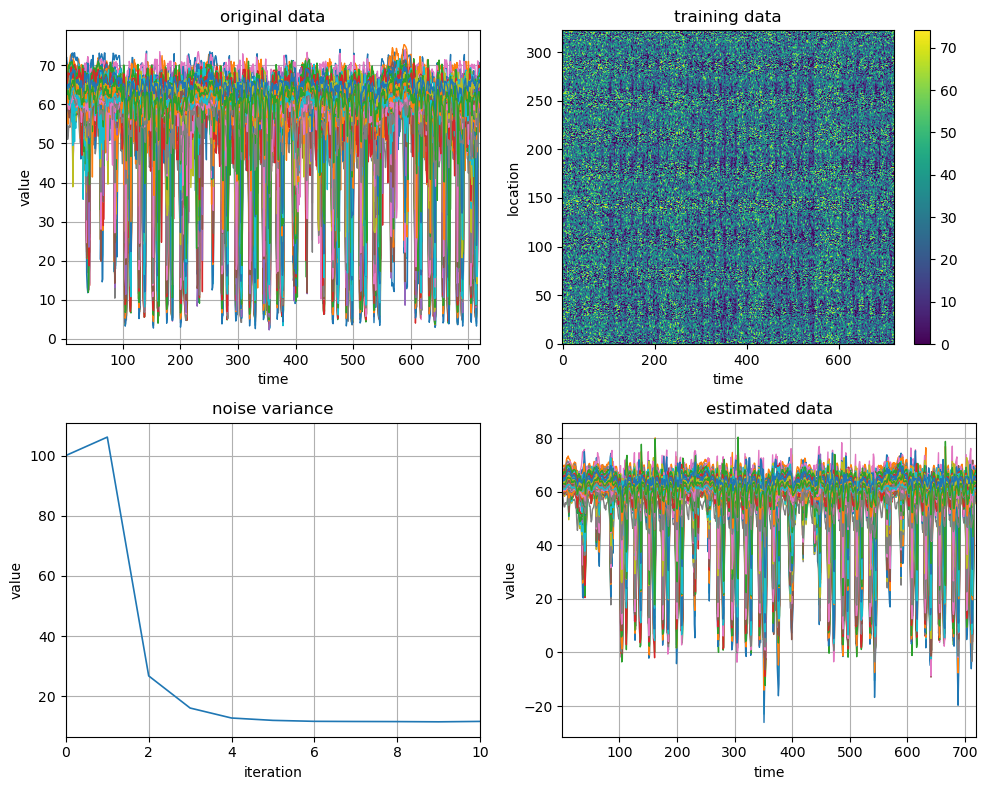

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)

x = np.arange(1, N[1] + 1)
axes[0,0].plot(x, I.T, linewidth=1)
axes[0,0].set_title("original data")
axes[0,0].grid(True)
axes[0,0].set_xlabel("time")
axes[0,0].set_ylabel("value")
axes[0,0].set_xlim(1, len(x))

im = axes[0,1].imshow(I * mask_matrix, aspect="auto", origin="lower")
axes[0,1].set_title("training data")
axes[0,1].set_xlabel("time")
axes[0,1].set_ylabel("location")
fig.colorbar(im, ax=axes[0,1])

axes[1,0].plot(1.0 / tau, linewidth=1.2)
axes[1,0].set_title("noise variance")
axes[1,0].grid(True)
axes[1,0].set_xlabel("iteration")
axes[1,0].set_ylabel("value")
axes[1,0].set_xlim(0, 10)

axes[1,1].plot(Y_est_.T, linewidth=1)
axes[1,1].set_title("estimated data")
axes[1,1].grid(True)
axes[1,1].set_xlabel("time")
axes[1,1].set_ylabel("value")
axes[1,1].set_xlim(1, N[1])

plt.show()

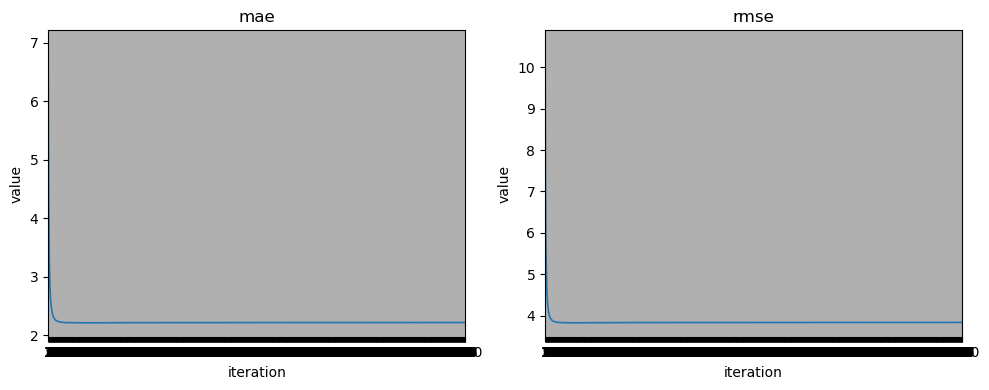

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
x = np.arange(1, len(mae) + 1)
axes[0].plot(x, mae, linewidth=1.2)
axes[0].set_title("mae")
axes[0].grid(True)
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("value")
axes[0].set_xlim(1, len(x))

axes[1].plot(x, rmse, linewidth=1.2)
axes[1].set_title("rmse")
axes[1].grid(True)
axes[1].set_xlabel("iteration")
axes[1].set_ylabel("value")
axes[1].set_xlim(1, len(x))

plt.show()